In [1]:
# /Users/chriswesterman/Library/Jupyter/nbextensions/snippets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
pd.set_option('display.max_columns', 500)


In [30]:
import pandas
x = pd.DataFrame({'Date': pd.date_range('6-1-2021', periods=30)})

x['DOW'] = x['Date'].dt.day_name()
x.head()

,Date,DOW
0,2021-06-01,Tuesday
1,2021-06-02,Wednesday
2,2021-06-03,Thursday
3,2021-06-04,Friday
4,2021-06-05,Saturday


In [25]:
import datetime as DT
import dateutil.relativedelta as REL

def get_thursday(x):
    rd = REL.relativedelta(days=0, weekday=REL.TH)
    next_thursday = x + rd
    return pd.to_datetime(next_thursday, format='%Y-%m-%d')

x['thursday'] = x.Date.apply(get_thursday)

x.head()

## Getting Netflix data 

### parsing raw files

In [ ]:
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
if not os.path.isfile('data.csv'):
    #read all txt file and store them in one big file
    data = open('data.csv', mode='w')
    
    row = list()
    files = ['./combined_data_2.txt',
            './combined_data_3.txt',
            './combined_data_1.txt',
            './combined_data_4.txt']
    for file in files:
        print('reading ratings from {}...'.format(file))
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    #all are rating
                    movid_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movid_id)
                    data.write(','.join(row))
                    data.write('\n')
        print('Done.\n')
    data.close()

In [ ]:
%%time
df = pd.read_csv('data.csv', sep=',', names=['movie','user','rating','date'])
df.head()

In [ ]:
df.rating.mean()

### Grouping by movies 

In [ ]:
%%time
# retrieve the avg score and number of ratings for each movie
review_count = df.groupby('movie')['rating'].agg(['mean', 'count'])
review_count.head()

In [ ]:
review_count.shape

In [ ]:
review_count['mean'].mean()

### loading titles

In [ ]:
df_title = pd.read_csv('./movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title = df_title.set_index('Movie_Id').dropna()
df_title.Year = df_title.Year.apply(int)
df_title.head(3)


In [ ]:
df_title = df_title.drop_duplicates()

In [ ]:
full_movies = review_count.merge(df_title, left_index=True, right_index=True)
full_movies.columns = ['avg_review_score', 'n_reviews', 'year','title']
display(full_movies.shape)
full_movies.tail()

In [ ]:
full_movies.isna().sum()

In [ ]:
full_movies.avg_review_score.mean()

### Optional Filtering active

In [ ]:
# slim down to movies with active user engagment
engaged_movies = full_movies.query('n_reviews >= 1000')
display(engaged_movies.shape)

engaged_movies.sort_values('n_reviews').head(3)

sns.histplot(engaged_movies['n_reviews'], bins=150, binrange=(250,9999));
plt.show();

sns.scatterplot(x='n_reviews', y='avg_review_score', data=engaged_movies);
plt.show();

### take a small sample

In [ ]:
mid_size_sample = full_movies.sample(200)
mid_size_sample.head()

### Creating DF from IMDB database

#### API test

In [19]:
url = f"http://www.omdbapi.com/?t=The Departed&apikey=ef5507df"
response = requests.get(url).json()

In [20]:
response

{'Title': 'The Departed',
 'Year': '2006',
 'Rated': 'R',
 'Released': '06 Oct 2006',
 'Runtime': '151 min',
 'Genre': 'Crime, Drama, Thriller',
 'Director': 'Martin Scorsese',
 'Writer': 'William Monahan, Alan Mak, Felix Chong',
 'Actors': 'Leonardo DiCaprio, Matt Damon, Jack Nicholson',
 'Plot': 'An undercover cop and a mole in the police attempt to identify each other while infiltrating an Irish gang in South Boston.',
 'Language': 'English, Cantonese',
 'Country': 'United States, Hong Kong',
 'Awards': 'Won 4 Oscars. 97 wins & 141 nominations total',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTI1MTY2OTIxNV5BMl5BanBnXkFtZTYwNjQ4NjY3._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.5/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '90%'},
  {'Source': 'Metacritic', 'Value': '85/100'}],
 'Metascore': '85',
 'imdbRating': '8.5',
 'imdbVotes': '1,215,175',
 'imdbID': 'tt0407887',
 'Type': 'movie',
 'DVD': '24 Oct 2008',
 'BoxOffice': '$132,384,315'

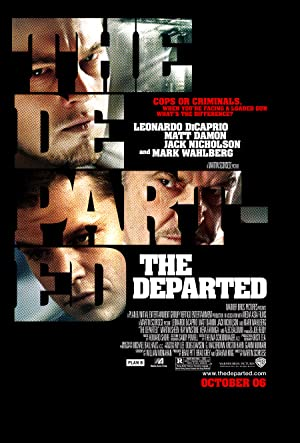

In [16]:
from IPython.display import Image
Image(response['Poster'])

#### Real deal

In [ ]:
from tqdm import tqdm

res = []
# comment out full loop for safety
for index, movie in tqdm(full_movies.iterrows(), total=full_movies.shape[0]):
    url = f'http://www.omdbapi.com/?t={movie["title"]}&apikey=ef5507df'
    response = requests.get(url).json()
    ratings = response.get('Ratings')
    if ratings:
        for rating in ratings:
            response[rating['Source']] = rating['Value']
        del response['Ratings']
    if response['Response'] == 'True':
        response['Index_match'] = index
        res.append(response)


imdb_df = pd.DataFrame(res)

In [ ]:
imdb_df.head(2)

### Merge Netflix and IMDB

In [ ]:
imdb_df.shape

In [ ]:
imdb_df.to_csv('full_scrape.csv', index=False)

In [ ]:
full_merge = full_movies.merge(imdb_df, how='inner', left_index=True, right_on='Index_match')

In [ ]:
display(full_merge.shape)
full_merge[['title', 'year']].duplicated().sum()

In [ ]:
full_merge.head(2)

In [ ]:
imdb_df[imdb_df.Title == 'The Forgotten']

In [ ]:
sns.histplot(full_merge.avg_review_score);

In [ ]:
full_merge.to_csv('scrape_merge_on_index.csv', index=False)

### Load merged df

In [ ]:
mine= 'scrape_merge_on_index.csv'
theirs = 'full_data_merged.csv'
merged_movies_csv = pd.read_csv(mine)

In [ ]:
merged_movies_csv.shape

In [ ]:
# theirs
# merged_movies_csv['mean'].mean()
# mine
merged_movies_csv['avg_review_score'].mean()

In [ ]:
merged_movies_csv.head(1)

In [ ]:
merged_movies_csv.isna().sum()

In [ ]:
# Theirs
# merged_movies_csv.dropna(subset=['Year_x'], inplace=True)
# merged_movies_csv['Year_x'] = merged_movies_csv['Year_x'].apply(int)
# merged_movies_csv['Year_y'] = merged_movies_csv['Year_y'].apply(lambda x: int(x[0:4]))

# mine
merged_movies_csv['year'] = merged_movies_csv['year'].apply(int)
merged_movies_csv['Year'] = merged_movies_csv['Year'].apply(lambda x: int(x[0:4]))


merged_movies_csv.head(2)

### Check if years and title match

In [ ]:
# theirs
# merged_movies_csv = merged_movies_csv[abs(merged_movies_csv['Year_x'] - merged_movies_csv['Year_y']) < 3]

# mine
merged_movies_csv = merged_movies_csv.loc[abs(merged_movies_csv['year'] - merged_movies_csv['Year']) < 3]

# Drop mismatch rows

In [ ]:
# theirs
# merged_movies_csv[merged_movies_csv['Name'] != merged_movies_csv['Title']]

# mine
merged_movies_csv[merged_movies_csv['title'] != merged_movies_csv['Title']].sample(5)

In [ ]:
merged_movies_csv.duplicated().sum()

In [ ]:
merged_movies_csv = merged_movies_csv.drop_duplicates()

In [ ]:
merged_movies_csv.shape

In [ ]:
merged_movies_csv.to_csv('merged_movies_by_index.csv', index=False)

In [ ]:
merged_movies_csv

### Rating Distribution

In [ ]:
sns.histplot(y_true, kde=True);

In [ ]:
merged_movies['People'] = merged_movies.apply(lambda x: x['Director'] + ',' + x['Writer'] + ',' + x['Actors'], axis=1)

In [ ]:
merged_movies.head(3)

## Working with IMDB

In [530]:
df = pd.read_csv('merged_movies_by_index.csv')

In [531]:
df.Rated.value_counts()

R            3542
PG-13        1252
Not Rated    1242
PG           1172
Approved      435
G             325
Unrated       294
Passed        200
TV-PG         132
TV-14         129
TV-G           57
TV-MA          56
TV-Y7          29
GP             22
TV-Y           20
NC-17          17
X              13
NOT RATED      13
M              12
UNRATED         9
M/PG            6
E               2
TV-Y7-FV        2
APPROVED        2
TV-13           1
Name: Rated, dtype: int64

In [532]:
df.Rated.isna().sum()

1402

### Count Vectorizer (people)

In [534]:
df['Genre'] = df['Genre'].fillna('N/A')
df['Actors'] = df['Actors'].fillna('N/A')
df['Writer'] = df['Writer'].fillna('N/A')
df['Rated'] = df['Rated'].fillna('Not Rated')
df['Director'] = df['Director'].fillna('N/A').str.replace('co director:','')
df['People'] = df['Actors'] + ',' + df['Director'] +',' + df['Writer']
df.head(3)

,avg_review_score,n_reviews,year,title,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Metascore,imdbRating,imdbVotes,imdbID,Type,totalSeasons,Response,Internet Movie Database,Index_match,DVD,BoxOffice,Production,Website,Rotten Tomatoes,Metacritic,Ratings,People
0,3.749543,547,2003,Dinosaur Planet,Dinosaur Planet,2003,Not Rated,14 Dec 2003,50 min,"Documentary, Animation, Family",N/A,N/A,"Christian Slater, Scott Sampson",A four-episode animated series charting the ad...,English,USA,Won 2 Primetime Emmys. Another 4 nominations.,https://m.media-amazon.com/images/M/MV5BNTY2MD...,NaN,7.7,447,tt0389605,series,NaN,True,7.7/10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Christian Slater, Scott Sampson,N/A,N/A"
1,3.641153,2012,1997,Character,Character,1997,R,27 Mar 1998,122 min,"Crime, Drama, Mystery",Mike van Diem,"Ferdinand Bordewijk (short story ""Dreverhaven ...","Jan Decleir, Fedja van Huêt, Betty Schuurman, ...","Jacob Katadreuffe lives mute with his mother, ...","Dutch, English, German, French","Netherlands, Belgium",Won 1 Oscar. Another 17 wins & 7 nominations.,https://m.media-amazon.com/images/M/MV5BNzUzMz...,NaN,7.7,"10,490",tt0119448,movie,NaN,True,7.7/10,3,04 Feb 2003,"$623,983",Almerica Film,NaN,92%,NaN,NaN,"Jan Decleir, Fedja van Huêt, Betty Schuurman, ..."
2,3.084396,1019,1997,Sick,Sick,1997,Not Rated,07 Nov 1997,90 min,Documentary,Kirby Dick,N/A,"Kathe Burkhart, Kirby Dick, Bob Flanagan, Sher...",Diagnosed with cystic fibrosis from a young ag...,English,USA,3 wins & 8 nominations.,https://m.media-amazon.com/images/M/MV5BMTkwND...,82.0,7.5,"1,569",tt0120126,movie,NaN,True,7.5/10,6,15 Feb 2017,"$116,806",Sick-the Life and Death of Bob Flanagan-Superm...,NaN,91%,82/100,NaN,"Kathe Burkhart, Kirby Dick, Bob Flanagan, Sher..."


In [535]:
from sklearn.feature_extraction.text import CountVectorizer

list_cols = ['Genre', 'Director', 'Actors', 'Writer','People']
vect_movies = df[list_cols + ['title']]
    
for col in list_cols:
    vect = CountVectorizer(token_pattern='[a-zA-Z][a-z -]+', max_features=100)

    X = vect.fit_transform(vect_movies[col])


    vect_movies = vect_movies.join(pd.DataFrame(X.toarray(), columns=[col + ' ' + name for name in vect.get_feature_names()])).drop(columns=col)

vect_movies.head()

,title,Genre action,Genre adult,Genre adventure,Genre animation,Genre biography,Genre comedy,Genre crime,Genre documentary,Genre drama,Genre family,Genre fantasy,Genre film-noir,Genre game-show,Genre history,Genre horror,Genre music,Genre musical,Genre mystery,Genre news,Genre reality-tv,Genre romance,Genre sci-fi,Genre short,Genre sport,Genre talk-show,Genre thriller,Genre war,Genre western,Director akira kurosawa,Director alan parker,Director alfred hitchcock,Director anthony mann,Director arthur hiller,Director avildsen,Director barry levinson,Director beth mccarthy-miller,Director billy wilder,Director blake edwards,Director bob clark,Director brian de palma,Director bruce beresford,Director carl reiner,Director chris columbus,Director clint eastwood,Director co-director,Director dave wilson,Director david mallet,Director edward dmytryk,Director fran,Director francis ford coppola,Director frank capra,Director fred schepisi,Director furie,Director garry marshall,Director george a,Director george cukor,Director george miller,Director george stevens,Director henry hathaway,Director herbert ross,Director howard hawks,Director james ivory,Director jim wynorski,Director joe dante,Director joel schumacher,Director john badham,Director john boorman,Director john carpenter,Director john ford,Director john frankenheimer,Director john g,Director john huston,Director john irvin,Director john landis,Director john r,Director john sayles,Director john schlesinger,Director john sturges,Director johnnie to,Director jonathan demme,Director joseph sargent,Director kevin dunn,Director lawrence jordan,Director lee thompson,Director martin scorsese,Director michael apted,Director michael curtiz,Director michael ritchie,Director michael schultz,Director mick jackson,Director mike nichols,Director norman jewison,Director norman tokar,Director ois truffaut,Director oliver stone,Director otto preminger,Director pakula,Director peter hyams,Director peter weir,Director peter yates,Director richard benjamin,Director richard donner,Director richard fleischer,Director ridley scott,Director robert altman,Director robert stevenson,Director robert wise,Director robert zemeckis,Director roman polanski,Director romero,Director ron howard,Director ronald neame,Director russell mulcahy,Director sidney lumet,Director simon wincer,Director spike lee,Director stanley donen,Director stanley kubrick,Director steven spielberg,Director sydney pollack,Director tim burton,Director tony scott,Director vincente minnelli,Director walter hill,Director wes craven,Director william a,Director william wyler,Director woody allen,Actors al pacino,Actors alec baldwin,Actors amitabh bachchan,Actors andy lau,Actors anthony hopkins,Actors arnold schwarzenegger,Actors ben affleck,Actors billy bob thornton,Actors brien,Actors bruce willis,Actors burt lancaster,Actors burt reynolds,Actors cary grant,Actors charlie sheen,Actors christian slater,Actors christopher walken,Actors clint eastwood,Actors connor,Actors dan aykroyd,Actors danny devito,Actors daryl hannah,Actors dennis hopper,Actors dennis quaid,Actors denzel washington,Actors donald sutherland,Actors dustin hoffman,Actors ed harris,Actors eddie murphy,Actors elvis presley,Actors eric roberts,Actors fox,Actors fran,Actors gabriel byrne,Actors gene hackman,Actors goldie hawn,Actors gregory peck,Actors hara,Actors harrison ford,Actors harvey keitel,Actors humphrey bogart,Actors jack lemmon,Actors jack nicholson,Actors jackson,Actors james caan,Actors james garner,Actors james stewart,Actors james woods,Actors jeff bridges,Actors john cusack,Actors john malkovich,Actors john travolta,Actors john wayne,Actors jon voight,Actors jos,Actors julia roberts,Actors kevin bacon,Actors kevin costner,Actors kirk douglas,Actors kurt russell,Actors liam neeson,Actors martin sheen,Actors mel gibson,Actors michael caine,Actors michael douglas,Actors michael keaton,Actors michelle pfeiffer,Actors morgan freeman,Actors neal,Actors nick nolte,Actors

### Ratings Mapping

In [536]:
RATINGS_MAP = {'R':'R', 'Not Rated': 'N/A', 'Passed': 'PG', 'PG': 'PG', 'PG-13': '13', 'G': 'G', 'TV-G': 'G',
       'Unrated': '17', 'Approved': 'PG', 'TV-13': '13', 'TV-14': '13', 'UNRATED': '17', 'TV-Y7': 'G',
       'NC-17': '17', 'TV-PG': 'PG', 'TV-MA': 'R', 'M/PG':'13', 'MA': 'R', 'NOT RATED': 'N/A', 'GP': 'PG', 'TV-Y': 'G',
       'X': '17', 'M':'R', 'APPROVED':'PG', 'E': 'G', 'TV-Y7-FV': 'G'}

In [537]:
df['Rated'] = df.Rated.map(RATINGS_MAP)

In [538]:
df.Rated.isna().sum()

0

In [541]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['Rated']])
OneHotEncoder(handle_unknown='ignore')
enc.categories_
# vect_movies = vect_movies.join(pd.DataFrame(enc.transform(df[['Rated']]).toarray(),columns=enc.categories))

[array(['13', '17', 'G', 'N/A', 'PG', 'R'], dtype=object)]

In [493]:
vect_movies.head()

,title,Genre action,Genre adult,Genre adventure,Genre animation,Genre biography,Genre comedy,Genre crime,Genre documentary,Genre drama,Genre family,Genre fantasy,Genre film-noir,Genre game-show,Genre history,Genre horror,Genre music,Genre musical,Genre mystery,Genre news,Genre reality-tv,Genre romance,Genre sci-fi,Genre short,Genre sport,Genre talk-show,Genre thriller,Genre war,Genre western,Director akira kurosawa,Director alan parker,Director albert pyun,Director alfred hitchcock,Director anthony mann,Director arthur hiller,Director barry levinson,Director beth mccarthy-miller,Director billy wilder,Director blake edwards,Director bob clark,Director brian de palma,Director bruce beresford,Director carl reiner,Director chris columbus,Director clint eastwood,Director co-director,Director dave wilson,Director david cronenberg,Director david mallet,Director federico fellini,Director fran,Director francis ford coppola,Director frank capra,Director fred schepisi,Director garry marshall,Director george cukor,Director george miller,Director george sidney,Director george stevens,Director harold becker,Director henry hathaway,Director herbert ross,Director howard deutch,Director howard hawks,Director james ivory,Director jim wynorski,Director joe dante,Director joel schumacher,Director john badham,Director john carpenter,Director john ford,Director john frankenheimer,Director john g,Director john huston,Director john irvin,Director john landis,Director john mctiernan,Director john r,Director john sayles,Director john schlesinger,Director john sturges,Director johnnie to,Director jonathan demme,Director joseph sargent,Director lawrence jordan,Director lee thompson,Director martin scorsese,Director michael apted,Director michael curtiz,Director michael ritchie,Director michael schultz,Director mick jackson,Director mike nichols,Director norman jewison,Director norman tokar,Director ois truffaut,Director otto preminger,Director paul hunter,Director peter hyams,Director peter weir,Director peter yates,Director richard benjamin,Director richard donner,Director richard fleischer,Director ridley scott,Director robert altman,Director robert stevenson,Director robert wise,Director robert zemeckis,Director ron howard,Director ronald neame,Director russell mulcahy,Director sidney j,Director sidney lumet,Director simon wincer,Director spike lee,Director stanley donen,Director stanley kubrick,Director steven soderbergh,Director steven spielberg,Director sydney pollack,Director tim burton,Director tony scott,Director vincente minnelli,Director walter hill,Director wes craven,Director william a,Director william wyler,Director woody allen,Actors al pacino,Actors alec baldwin,Actors amitabh bachchan,Actors andy lau,Actors anthony hopkins,Actors arnold schwarzenegger,Actors ben affleck,Actors billy bob thornton,Actors brien,Actors bruce willis,Actors burt lancaster,Actors burt reynolds,Actors cary grant,Actors charlie sheen,Actors christian slater,Actors christopher walken,Actors clint eastwood,Actors connor,Actors dan aykroyd,Actors danny devito,Actors daryl hannah,Actors dennis hopper,Actors dennis quaid,Actors denzel washington,Actors donald sutherland,Actors dustin hoffman,Actors ed harris,Actors eddie murphy,Actors elvis presley,Actors eric roberts,Actors fox,Actors fran,Actors gabriel byrne,Actors gene hackman,Actors goldie hawn,Actors gregory peck,Actors hara,Actors harrison ford,Actors harvey keitel,Actors humphrey bogart,Actors jack lemmon,Actors jack nicholson,Actors jackson,Actors james caan,Actors james garner,Actors james stewart,Actors james woods,Actors jeff bridges,Actors jeff daniels,Actors john cusack,Actors john malkovich,Actors john travolta,Actors john wayne,Actors jon voight,Actors jos,Actors julia roberts,Actors kevin bacon,Actors kevin costner,Actors kiefer sutherland,Actors kirk douglas,Actors kurt russell,Actors liam neeson,Actors martin sheen,Actors mel gibson,Actors michael caine,Actors michael douglas,Actors michelle pfeiffe

In [ ]:
# Runtime 

### Turning string columns into lists

In [ ]:
list_cols = ['Genre','Director','Writer','Actors','Language','Country','Production']
for col in list_cols:
    merged_movies[col] = merged_movies[col].apply(lambda x: x.split(','))

In [ ]:
merged_movies.head()

### Encoding list columns

In [ ]:
for column in list_cols:
    display(pd.get_dummies(merged_movies[column].apply(pd.Series).stack()).sum(level=0))

## Simple Pipeline

### Dummy Regressor

In [437]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance

In [17]:
df = pd.read_csv('../raw_data/merged_movies_by_index.csv')
df = df[df['Type'] != 'series'].copy()
df['Type'].value_counts()
df.head()

,avg_review_score,n_reviews,year,title,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Metascore,imdbRating,imdbVotes,imdbID,Type,totalSeasons,Response,Internet Movie Database,Index_match,DVD,BoxOffice,Production,Website,Rotten Tomatoes,Metacritic,Ratings
1,3.641153,2012,1997,Character,Character,1997,R,27 Mar 1998,122 min,"Crime, Drama, Mystery",Mike van Diem,"Ferdinand Bordewijk (short story ""Dreverhaven ...","Jan Decleir, Fedja van Huêt, Betty Schuurman, ...","Jacob Katadreuffe lives mute with his mother, ...","Dutch, English, German, French","Netherlands, Belgium",Won 1 Oscar. Another 17 wins & 7 nominations.,https://m.media-amazon.com/images/M/MV5BNzUzMz...,NaN,7.7,"10,490",tt0119448,movie,NaN,True,7.7/10,3,04 Feb 2003,"$623,983",Almerica Film,NaN,92%,NaN,NaN
2,3.084396,1019,1997,Sick,Sick,1997,Not Rated,07 Nov 1997,90 min,Documentary,Kirby Dick,NaN,"Kathe Burkhart, Kirby Dick, Bob Flanagan, Sher...",Diagnosed with cystic fibrosis from a young ag...,English,USA,3 wins & 8 nominations.,https://m.media-amazon.com/images/M/MV5BMTkwND...,82.0,7.5,"1,569",tt0120126,movie,NaN,True,7.5/10,6,15 Feb 2017,"$116,806",Sick-the Life and Death of Bob Flanagan-Superm...,NaN,91%,82/100,NaN
3,2.129032,93,1992,8 Man,8 Man,1992,NaN,NaN,83 min,"Action, Sci-Fi",Yasuhiro Horiuchi,"Kazumasa Hirai (comic-book), Jirô Kuwata (comi...","Kai Shishido, Etsushi Takahashi, Sachiko Ayase...",After Tokyo police officer Yokoda is killed in...,Japanese,Japan,NaN,https://m.media-amazon.com/images/M/MV5BMTMxNz...,NaN,5.4,78,tt0182668,movie,NaN,True,5.4/10,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.417582,546,1947,My Favorite Brunette,My Favorite Brunette,1947,Passed,04 Apr 1947,87 min,"Comedy, Crime, Mystery, Romance, Thriller",Elliott Nugent,"Edmund Beloin (original screenplay), Jack Rose...","Bob Hope, Dorothy Lamour, Peter Lorre, Lon Cha...",Shortly before his execution on the death row ...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BZWViOW...,NaN,6.8,"3,097",tt0039645,movie,NaN,True,6.8/10,12,10 Mar 2016,NaN,"Paramount Pictures, Hope Enterprises",NaN,75%,NaN,NaN
5,3.286207,290,1988,Neil Diamond: Greatest Hits Live,Neil Diamond: Greatest Hits Live,1988,NaN,30 Jan 1991,60 min,"Documentary, Music","Dwight Hemion, Peter Israelson","Kenny Solms (writing supervisor), Ann Elder, T...","Neil Diamond, Richard Bennett, Vince Charles, ...",NaN,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BMjExNT...,NaN,8.0,71,tt0168093,movie,NaN,True,8.0/10,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.Production.value_counts()

Paramount Pictures                                                                         162
Miramax                                                                                    153
Columbia Pictures Corporation                                                              122
Universal Pictures                                                                         109
Twentieth Century Fox                                                                      107
                                                                                          ... 
Alcor Films, Warner Bros., Canal+, Regency Enterprises                                       1
Lakeshore Entertainment, Mosaic Media Group                                                  1
Norsk Film, Norsk Rikskringkasting                                                           1
Halperin Productions                                                                         1
The Shooting Gallery, Miramax Films, WMG Film, Ind

In [286]:
RATINGS_MAP = {'R':'R', 'Not Rated': 'Unrated', 'Passed': 'PG', 'PG': 'PG', 'PG-13': '13', 'G': 'G', 'TV-G': 'G',
       'Unrated': 'Unrated', 'Approved': 'PG', 'TV-13': '13', 'TV-14': '13', 'UNRATED': 'Unrated', 'TV-Y7': 'G',
       'NC-17': '17', 'TV-PG': 'PG', 'TV-MA': 'R', 'M/PG':'13', 'MA': 'R', 'NOT RATED': 'Unrated', 'GP': 'PG', 'TV-Y': 'G',
       'X': '17', 'M':'R', 'APPROVED':'PG', 'E': 'G', 'TV-Y7-FV': 'G'}

In [259]:
import re
def clean_runtime(x):
    counter = 0
    if 'h' in x:
        counter += int(x[0]) * 60
        x = re.sub('.*h', '', x).strip()
    x = x.replace('min', '').replace(',','').strip()
    counter += int(x)
    return counter
    

In [463]:
# /Users/chriswesterman/Library/Jupyter/nbextensions/snippets
simple_df = df[['Writer','Actors', 'Director', 'Genre','Runtime', 'Rated', 'Plot', 'avg_review_score']].copy()
simple_df = simple_df.dropna()
simple_df['Runtime'] = simple_df['Runtime'].apply(clean_runtime)
simple_df['Rated'] = simple_df['Rated'].map(RATINGS_MAP)

# simple_df['Director'] = simple_df['Director'].str.replace('co director:', '')
X = simple_df[['Actors', 'Runtime', 'Rated', 'Genre', 'Director','Writer']]
y = simple_df.avg_review_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [461]:
X.shape

(8380, 6)

In [473]:
pipe_actor = Pipeline([('act_count', CountVectorizer(token_pattern='[a-zA-Z][a-z -]+', max_features=100))])

pipe_genre = Pipeline([('Genre', CountVectorizer(token_pattern='[a-zA-Z][a-z -]+', max_features=20))])

pipe_writer = Pipeline([('writer_count', CountVectorizer(token_pattern='[a-zA-Z][a-z -]+', max_features=20))])

pipe_director = Pipeline([('director_count', CountVectorizer(token_pattern='[a-zA-Z][a-z -]+', max_features=30))])

pipe_rated = Pipeline([('rated_OHE', OneHotEncoder(handle_unknown='ignore'))])

# pipe_plot = Pipeline([(     )])

pipe_runtime = Pipeline([('scaler', MinMaxScaler())])

pre_processing_pipe = ColumnTransformer([('actor', pipe_actor, 'Actors'),
                                         ('director', pipe_director, 'Director'),
                                         ('genre', pipe_genre, 'Genre'),
                                         ('rated', pipe_rated, ['Rated']),
                                         ('writer', pipe_writer, 'Writer'),
                                        ('runt', pipe_runtime, ['Runtime'])])

final_pipe = Pipeline(steps=[('features', pre_processing_pipe),
                             ('model', XGBRegressor(booster='gbtree', sampling_method='gradient_based', max_depth=5, gamma=0.001))]);
                             #('model', RandomForestRegressor(n_estimators=100,min_samples_split=25, min_samples_leaf=40 , max_depth=50))]);

                            #('model', DecisionTreeRegressor(min_samples_split=25, min_samples_leaf=40 , max_depth=50))]);

In [474]:
final_pipe.fit(X_train, y_train);

In [475]:
y_train_pred = final_pipe.predict(X_train)
y_test_pred = final_pipe.predict(X_test)

In [476]:
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print('Test: ',rmse_test)
print('Train: ',rmse_train)

Test:  0.4123438418408298
Train:  0.35658043714286536


### Feature Importance

In [468]:
permutation_score = permutation_importance(final_pipe, X, y, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

,feature,score decrease
1,Runtime,0.295149
3,Genre,0.215321
2,Rated,0.205231
0,Actors,0.083074
5,Writer,0.058897
4,Director,0.020412
